In [1]:
from datetime import date, timedelta
import geopandas, pandas as pd
from constants import *
from download import download
from geo import convert_df
from phe import plot_areas, recent_phe_data_summed, map_data as phe_map_data, plot_map as phe_plot_map
from zoe import latest_map_data as zoe_map_data, bokeh_plot_map as zoe_plot_map, add_simple_geoms
from plotting import matplotlib_zoe_vs_phe_map, geoplot_bokeh, save_to_disk, bokeh_zoe_vs_phe_map
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
# download cases data
force_download = False
for_date = date.today()-timedelta(days=1)
suffix = 'csv'
for type_ in 'cases', 'deaths':
    path = base_path / f'coronavirus-cases_{for_date}.{suffix}'
    if force_download or not path.exists():
        download(cases_url.format(data_type=suffix), path)

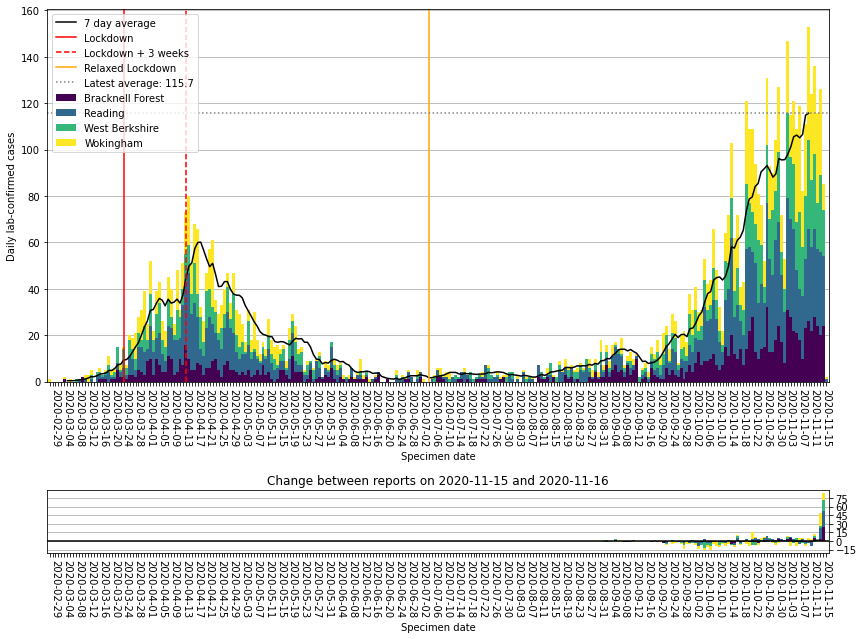

In [14]:
plot_areas(for_date, areas=my_areas, uncertain_days=5)

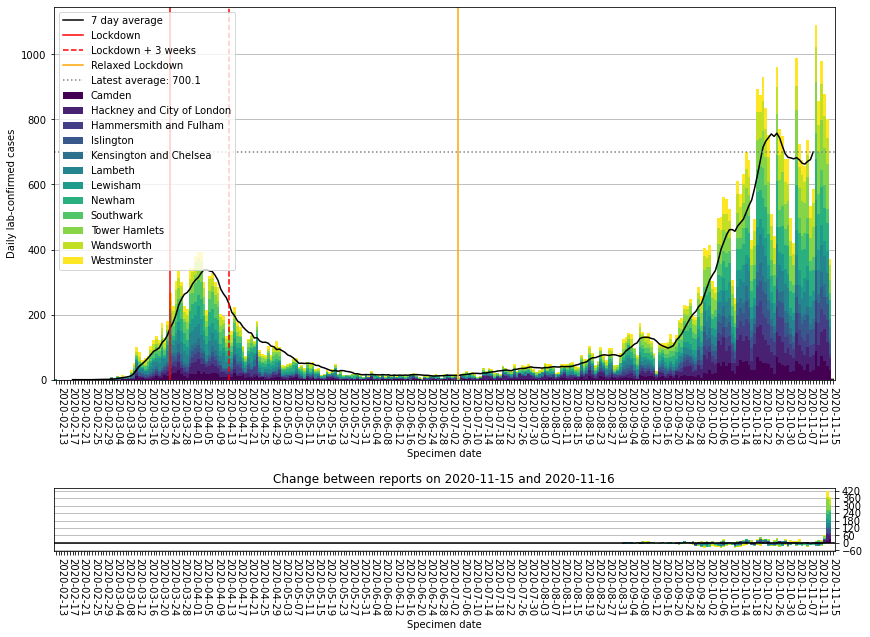

In [15]:
plot_areas(for_date, areas=london_areas, uncertain_days=6)

In [16]:
top_10_types = ltla
data = recent_phe_data_summed(for_date, by=top_10_types)
top_10 = data.sort_values(per100k, ascending=False)[:10][[area,per100k,cases,specimen_date]]
top_10

,Area name,"cases per 100,000 people",Daily lab-confirmed cases,Specimen date
Area code,,,,
E06000010,"Kingston upon Hull, City of",663.354371,1729.0,2020-11-15
E07000113,Swale,547.404709,813.0,2020-11-15
E06000001,Hartlepool,499.774780,466.0,2020-11-15
E06000021,Stoke-on-Trent,485.863825,1243.0,2020-11-15
E08000027,Dudley,484.988741,1555.0,2020-11-15
E06000008,Blackburn with Darwen,481.395443,717.0,2020-11-15
E08000034,Kirklees,477.062045,2093.0,2020-11-15
E07000137,East Lindsey,476.051755,670.0,2020-11-15
E08000004,Oldham,474.062379,1117.0,2020-11-15


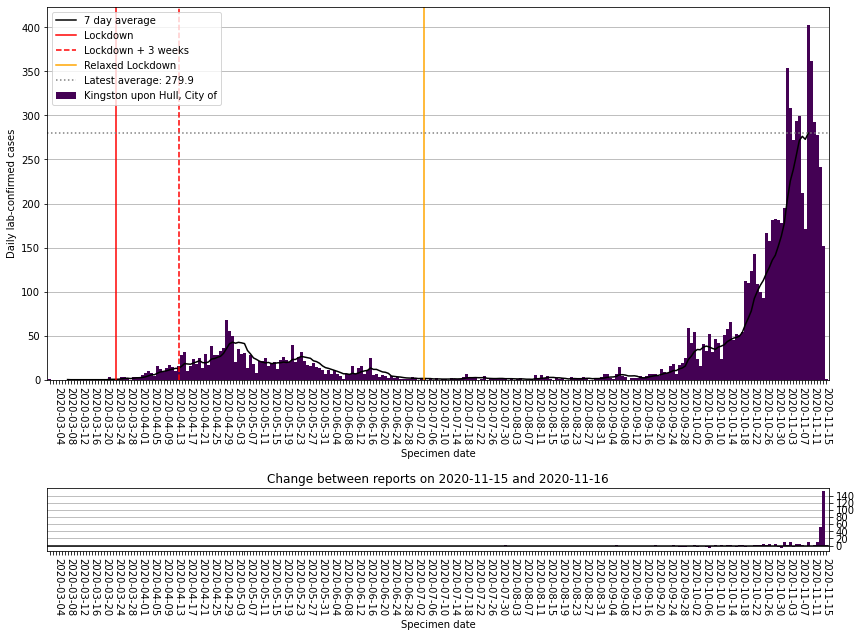

In [25]:
plot_areas(for_date, areas = [top_10.iloc[0].name], area_types=top_10_types, uncertain_days=5)

In [20]:
zoe_date, zoe_df = zoe_map_data()

In [21]:
phe_recent_date, phe_recent_geo = phe_map_data(for_date)
phe_recent_title = (
    'PHE lab-confirmed cases summed over last ' 
    f"{int(phe_recent_geo['recent_days'].iloc[0])} days to {phe_recent_date:%d %b %Y}"
)

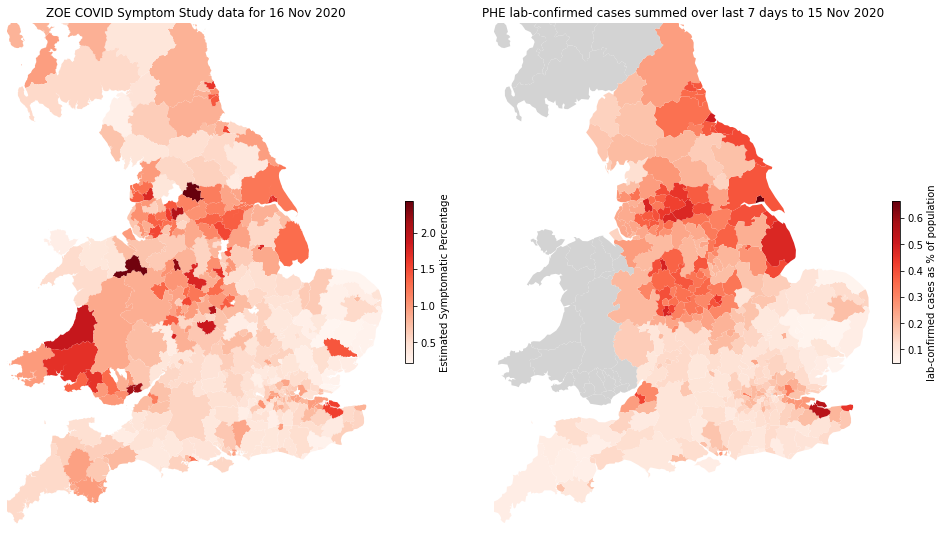

In [22]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)   

In [23]:
zoe_new_lad16 = add_simple_geoms(zoe_df)

In [24]:
bokeh_zoe_vs_phe_map(zoe_new_lad16, zoe_date, phe_recent_geo, phe_recent_title)

Loading BokehJS ...

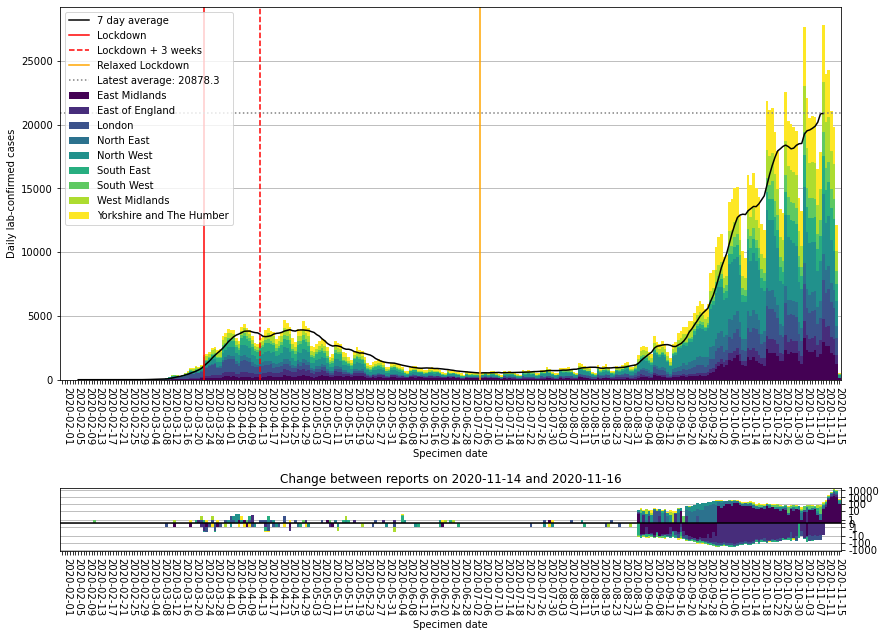

In [27]:
from functools import partial
from phe import plot_with_diff, data_for_date
plot_with_diff(
    for_date-,
    partial(data_for_date, area_types=region),
    uncertain_days=5, 
    diff_days=2,
    diff_log_scale=True,
)